In [7]:
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)
from sklearn.model_selection import KFold
from util import getNowTime,transformImg
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from postProcess.post_proc import post_proc


CFG = {
    "batch_size": 1,
    "num_epoch":10,
    # 不同损失所占的额权重比
    "dice_weight":0.5
}



(256, 256, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(3, 256, 256) (256, 256) (256, 256)


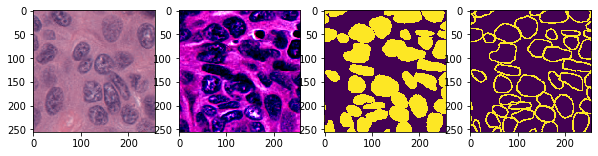

In [8]:
'''
显示训练集里面的一些结果
'''
imgs = np.load('../dataset/trainDataSet.npy')
labels = np.load('../dataset/labelDataSet.npy')
bounds = np.load('../dataset/boundDataSet.npy')

pathologyDataSet = PathologyDataSet(imgs, labels, bounds)
# 获取训练集的数据
# pathologyDataLoader = DataLoader(pathologyDataSet, shuffle=True, batch_size=CFG['batch_size'])
# iterator = iter(pathologyDataLoader)
# img, seg_label, boundary_label = iterator.first()
# img0 = img[0]
# img_seg_label = seg_label[0]
# img_boundary_label = boundary_label[0]
# b = img_seg_label
# c = img_boundary_label

source_img = imgs[0][0:256,0:256,:]
print(source_img.shape)

img, seg_label, boundary_label = pathologyDataSet[0]
print(img.shape,seg_label.shape,boundary_label.shape)
init_img = np.transpose(img,(1,2,0))
showLineImg([source_img,init_img,seg_label,boundary_label])



In [3]:
'''
infer
'''
'''
# 首先先对图片进行染色归一化处理
from StainProcess.StainNormalization import normalizeStaining
from ImageProcess.ImageProcess import cv2Bgr2Rgb

imgPath = '../dataset/inferImage/slideImage.png'
img = cv2Bgr2Rgb(imgPath)
gen_image = img[1000:1256,1000:1256,:]
# 染色归一化
norm_image,_,_ = normalizeStaining(gen_image)
trans_img= transformImg(norm_image)
trans_img_transpose = np.transpose(trans_img,(1,2,0))
'''


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3, 1, 1).to(device)
model.load_state_dict(torch.load('../train_model/segModel_800.pth'))


<All keys matched successfully>

In [10]:
def infer(model,img):
    img_copy_copy = img.transpose(2,0,1)
    img_copy_copy = np.expand_dims(img_copy_copy,0)
    img_copy_copy = torch.tensor(img_copy_copy).float().to(device)
    sout, sout_0, sout_1, sout_2, sout_3, cout, cout_0, cout_1, cout_2, cout_3 = model(img_copy_copy)
    return sout.cpu().data.numpy()[0][0], cout.cpu().data.numpy()[0][0]




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


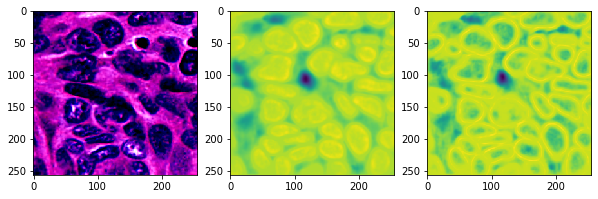

In [11]:
sout,cout = infer(model,init_img)
showLineImg([init_img,sout,cout],figsize=(10,6))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


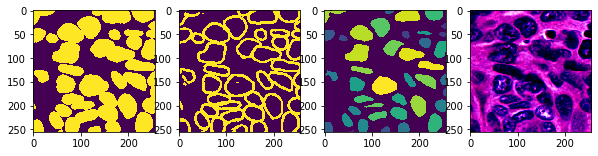

In [25]:

img_semantic = post_proc(sout,cutoff=0.5,post_dilation_iter=1)
img_outline1 = post_proc(cout,cutoff=0.5,post_dilation_iter=1,post_fill_holes=False)
# img_outline2 = post_proc(sout-cout,post_dilation_iter=0)
# showLineImg([img_semantic,cout,img_outline1,img_outline2])


img_semantic[img_semantic != 0]=1
img_outline1[img_outline1 != 0]=1
result = post_proc(img_semantic-img_outline1,post_dilation_iter=0)

showLineImg([img_semantic,img_outline1,result,init_img])



In [14]:
import numpy as np
import torch.nn.functional as F
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)
from sklearn.model_selection import KFold
from util import getNowTime,transformImg
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from postProcess.post_proc import post_proc
from util import getNowTime,transformImg,extract_patches,reconstruct_from_patches_weightedall,test_extract_patches







(1, 3, 1000, 1000)


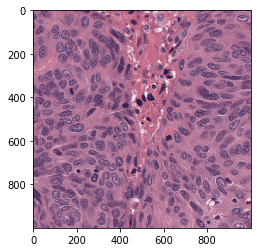

In [13]:
images = np.load('../dataset/trainDataSet.npy')
images0 = images[0]


images0_0 = np.transpose(images0,(2,0,1))
images0_0 = np.expand_dims(images0_0,0)
print(images0_0.shape)

plt.imshow(images0)
plt.show()




In [19]:
result_img_tensor = torch.FloatTensor(images0_0)
print(result_img_tensor.shape)

result_img = test_extract_patches(result_img_tensor,256,128)
print(result_img.shape)

torch.Size([1, 3, 1000, 1000])
torch.Size([1, 3, 1152, 1152])


In [26]:
final_img = result_img.numpy()
# final_img = np.transpose(final_img[0],(1,2,0))
final_img = final_img[0]
print(final_img.shape)


(3, 1152, 1152)


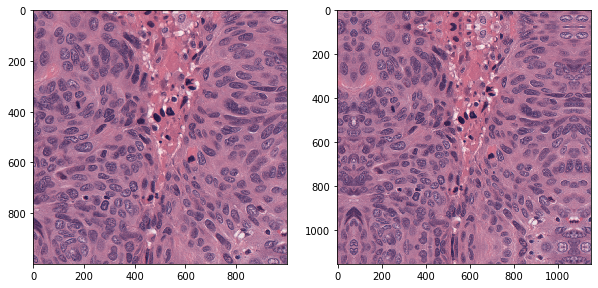

In [35]:
hha = np.transpose(final_img,(1,2,0))
hha = hha.astype(np.int)


fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(images0)
ax[1].imshow(hha)


In [33]:
print(hha.shape)

(1152, 1152, 3)
